# Architectures to solve simple memory tasks

This repo is to experiment with implementing simple memory tasks in RL. The tasks considered here are: 
- Remember lights task 
  - Works great!
- Line world task 
  - Works only if I run it for very long with small learning rate, trying to make this more efficient.

Implemented architectures:
- LSTM
- RNN
- LSTM with DNC

Thanks to Tristan Deleu for helping me with the code. Thanks for Anthony Chen, I got inspired to do this after my conversation with him.

Things to try next:
- Exponential decay of states with a trace, and learning using a linear agent.



## Results

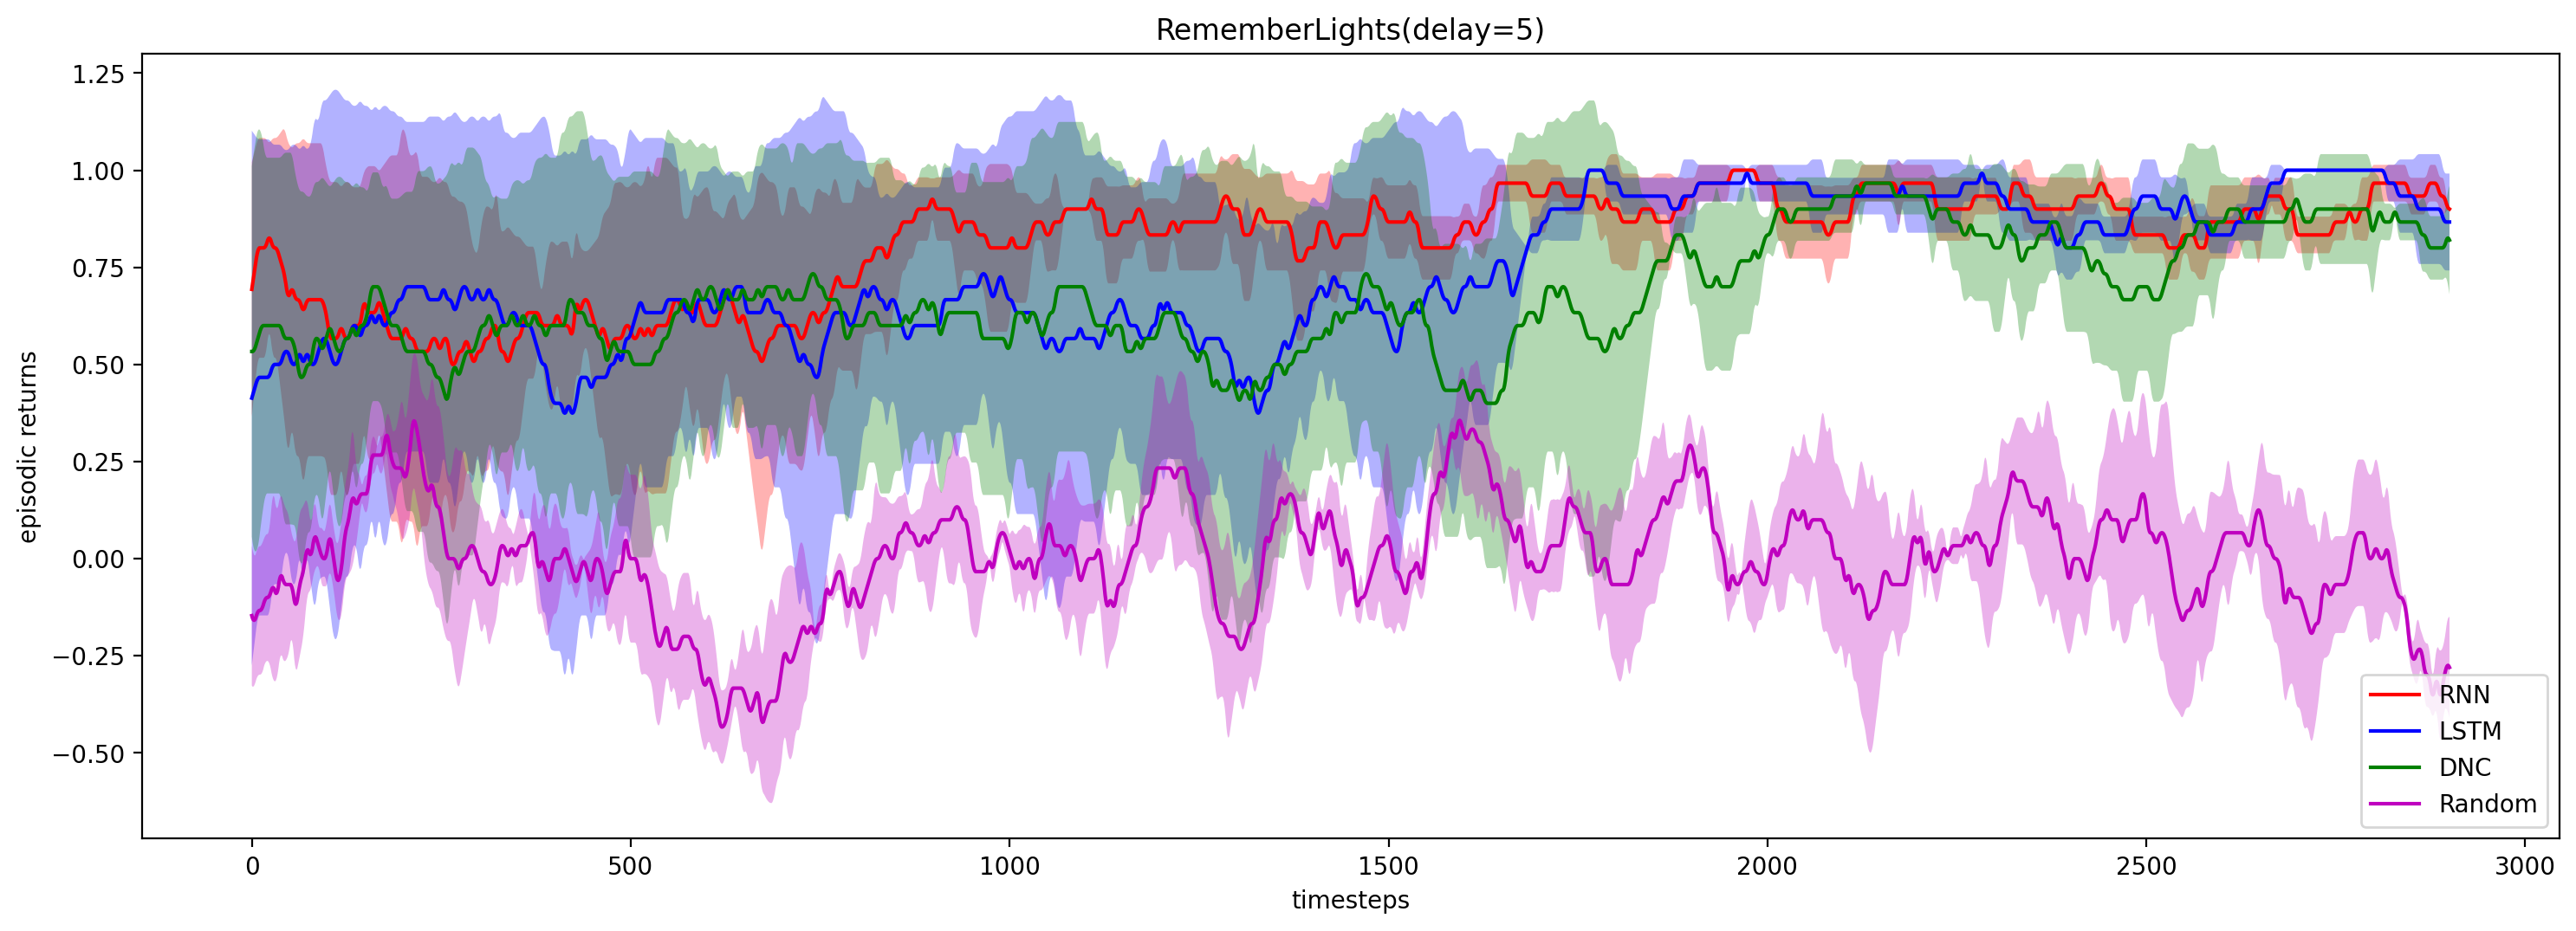

## Installing and ensuring DNC works

In [0]:
!git clone https://github.com/ixaxaar/pytorch-dnc
%cd pytorch-dnc
!pip install -r ./requirements.txt
!pip install -e .

Cloning into 'pytorch-dnc'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 888 (delta 0), reused 1 (delta 0), pack-reused 884
Receiving objects: 100% (888/888), 738.31 KiB | 13.42 MiB/s, done.
Resolving deltas: 100% (580/580), done.
/content/pytorch-dnc
     |████████████████████████████████| 10.5MB 2.7MB/s 
     |████████████████████████████████| 582.5MB 23kB/s 
  Created wheel for pyflann3: filename=pyflann3-1.8.4.1-cp36-none-any.whl size=10663418 sha256=abf5d15aa56a19183a29bb894d2b6b3dceef07dda06e1e5827155f746f6acf80
  Stored in directory: /root/.cache/pip/wheels/14/31/97/b7eb1b290c97ddad53bcc16eaacc5beee06393f4246eb60173
Successfully built pyflann3
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 1.0.1.post2 which is incompatible.
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1

In [0]:
from dnc import DNC
import torch

dnc = DNC(
  input_size=2,
  hidden_size=5,
  rnn_type='lstm',
  num_layers=1,
  nr_cells=10,
  cell_size=10,
  read_heads=2,
  batch_first=True,
  gpu_id=-1
)

(controller_hidden, memory, read_vectors) = (None, None, None)

output, (controller_hidden, memory, read_vectors) = \
  dnc(torch.randn(1, 4, 2), (controller_hidden, memory, read_vectors), reset_experience=True)
print(output.shape)

torch.Size([1, 4, 2])


## Setting up gym environments

In [0]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from gym.utils import seeding

### Remember lights task

In [0]:
class RememberLights(gym.Env):
  def __init__(self, size=2, p=0, delay=3):
    
    # Setting things up
    self.updates = 0
    self.action_space = spaces.Discrete(2) # 0 - b1, 1 - b2
    self.observation_space = spaces.Box(low=np.zeros(2), high=np.ones(2), dtype=np.uint8) # as the state space is one hot encoded
    self.p = p # stocasticity
    self.delay = delay

    # Reward values
    self.correct_reward = 1
    self.wrong_reward = -1

  def reset(self):
    self.updates = 0
    self.lights = random.choice([[0,1],[1,0]])
    return self.lights

  def step(self, action):

    # Making sure valid action is chosen
    assert self.action_space.contains(action)

    self.updates += 1

    # If the environment is stocastic, you move equivalent to taking a random action
    if(np.random.rand() <= self.p):
      action = np.random.randint(low=0, high=2)

    
    done = False
    R = 0
    state = [0, 0]
    if(self.updates == self.delay):
      state = [1, 1] # choose now indicator
    elif(self.updates == self.delay + 1):
      done = True
      if(self.lights[action] == 1):
        R = self.correct_reward
      else:
        R = self.wrong_reward

    return state, R, done, {}


### Line world task

In [0]:
class LineWorld():
    """
    """
    def __init__(self, n=5):

        # Initialzing required parameters
        self.update_count = 0
        self.n = n # Length of the chain
        self.state = (n-1) // 2  # Start at middle of the chain
        self.action_space = spaces.Discrete(2) # Number of actions: 2 - [0: left, 1: right]
        # self.observation_space = spaces.Discrete(self.n) # number of states is equal to chain length
        self.observation_space = spaces.Box(low=np.zeros(n), high=np.ones(n), dtype=np.uint8)
        # Setting reward values
        self.step_reward = -1
        
        self.seed() # not sure what this does, so not changing it

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        '''
        takes an action as an argument and returns the next_state, reward, done, info.
        '''
        
        # Making sure valid action is chosen
        assert self.action_space.contains(action)

        self.update_count += 1

        # Stepping along on the chain
        if(action == 0):
            self.state = self.state - 1
        else:
            self.state = self.state + 1

        # Because this is a continuing case
        if((self.state == self.n-1) or (self.state == 0)):
            done = True
            reward = self.step_reward
        else:
            done = False
            reward = self.step_reward
        temp = np.zeros(self.observation_space.shape)
        temp[self.state] = 1

        return temp, reward, done, {}

    def reset(self):
        '''
        transitions back to first state
        '''
        self.update_count = 0 
        self.state = (self.n - 1) // 2
        temp = np.zeros(self.observation_space.shape)
        temp[self.state] = 1
        return temp

### Lineworld with memory task

In [0]:
class LineWorldMemory(gym.Env):
  def __init__(self, size=5, p=0, horizon=100):
    
    # Setting things up
    self.updates = 0
    self.size = size # size of the chain
    self.loc = (self.size - 1) // 2 # Start at the middle
    self.action_space = spaces.Discrete(2) # 0 - left, 1 - right, In term state: 0 - click blue, 1 - click green
    self.observation_space = spaces.Box(low=np.zeros(size+2), high=np.ones(size+2), dtype=np.uint8) # as the state space is one hot encoded
    self.p = p # stocasticity
    self.horizon = horizon

    # object choice
    self.color = random.choice(['blue', 'green'])
    self.color2val = {'blue':0, 'green':1}

    # Reward values
    self.step_reward = -0.1
    self.correct_reward = 0
    self.wrong_reward = -2

  def reset(self):
    self.updates = 0
    self.loc = (self.size - 1) // 2 # Start at the middle
    self.color = random.choice(['blue', 'green'])
    return self._loc2state(self.loc)

  def _loc2state(self, loc):
    temp = np.zeros(self.observation_space.shape[0])
    temp[loc] = 1
    if(self.loc == 0):
      temp[self.size + self.color2val[self.color]] = 1
    return temp

  def step(self, action):

    # Making sure valid action is chosen
    assert self.action_space.contains(action)

    self.updates += 1

    # If the environment is stocastic, you move equivalent to taking a random action
    if(np.random.rand() <= self.p):
      action = np.random.randint(low=0, high=4)

    done = False
    # Checking for termination
    R = self.step_reward
    if(self.updates >= self.horizon):
      done = True
    elif((self.loc == self.size-1)):
      done = True
      if(action == self.color2val[self.color]):
        R = self.correct_reward
      else:
        R = self.wrong_reward

    if(not done):
      # Stepping along on the chain
      if(action == 0):
          self.loc = self.loc - 1
      elif(action == 1):
          self.loc = self.loc + 1

      # Compensating for walls
      if(self.loc < 0):
        self.loc = 0
      elif(self.loc >= self.size):
        self.loc = self.size - 1

    
        
    return self._loc2state(self.loc), R, done, {}

  def render(self, mode='human', printR=False, cs=100):
    '''Rendering the state of environment
    
    passing for now, need to implement a nice visualization later.
    
    '''
    self.cs = cs
    h = self.size*cs
    w = cs
    img = Image.new('RGBA', (h, w), "white")
    draw = ImageDraw.Draw(img)

    for i in range(1, self.size):
    	draw.line([cs*i, 0, cs*i, h], fill="gray", width=10)
     
    for i in range(0, self.size):
      if(i == self.size-1):
        draw.ellipse([i*cs, 0, i*cs+cs, cs], fill="black")
      if(i == 0):
        draw.ellipse([0, 0, cs/2, cs/2], fill=self.color)
      if(i == self.loc):
        draw.ellipse([i*cs+cs/3, cs/3, i*cs+cs*2/3, 2*cs/3], fill="red")

    plt.title('red: agent | black: choose state')

    if(mode=="human"):
      plt.imshow(img)
      plt.show()

    elif(mode=="rgb_array"):
      return img
  


### Testing the environment

In [0]:
# Testing the environemnt
TEST = False
env = LineWorldMemory()
print('Setting up environment...')
print(env.reset())
if(TEST):
  for i in range(10):
    env.render()
    action = input('Choose your action: ')
    rets = env.step(int(action))
    print(rets)
    if(rets[2]):
      break

Setting up environment...
[0. 0. 1. 0. 0. 0. 0.]


## Implementing the agent


### Setting things up: libraries and utility functions

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

  
def plot_rewards(rewards, plot_seperate=True , clip=10000, title='unnamed',smooth=5):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6), dpi=200)
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip-smooth+1))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = convolve(np.interp(np.arange(clip), t, r), smooth)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(loc='lower right'), plt.show()

### Networks to learn q value

In [0]:
class RecurrentNet(nn.Module):
  def __init__(self, in_size=2, hidden_size=2, out_size=2, style='lstm'):
    """
    in_size -> state space goes in here, so size of the state features
    hidden_size -> hidden vector size in the LSTM
    out_size -> number of actions
    """
    super(RecurrentNet, self).__init__()
    self.hidden_size = hidden_size
    self.style = style
    if(style=='lstm'):
      self.rnn = nn.LSTM(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True)
    elif(style=='rnn'):
      self.rnn = nn.RNN(input_size=in_size, hidden_size=hidden_size, num_layers=1, batch_first=True, nonlinearity='tanh')
    elif(style=='dnc'):
      self.rnn = DNC(
                      input_size=in_size,
                      hidden_size=hidden_size,
                      rnn_type='lstm',
                      num_layers=1,
                      nr_cells=10,
                      cell_size=10,
                      read_heads=2,
                      batch_first=True,
                      gpu_id=-1
                    )
    else:
      raise

    if(style=='dnc'):
      self.fc_head = nn.Linear(in_size, out_size)
    else:
      self.fc_head = nn.Linear(hidden_size, out_size)
    # for p in list(self.parameters()): # initialize all parameters to 0
    #   p.data.fill_(0)
   
    self.hidden_state = torch.zeros(1, 1, hidden_size) # layer x bs x hidden_dims
    
  def reset_hidden_states(self):
    return torch.zeros(1, 1, self.hidden_size) # layer x bs x hidden_dims
  
  def forward(self, x): 
    """
    x -> timesteps x num_features
    """
    if(self.style=='lstm'):
      hidden_state =  (torch.zeros(1, 1, self.hidden_size),torch.zeros(1, 1, self.hidden_size))
    elif(self.style == 'rnn'):
      hidden_state = torch.zeros(1, 1, self.hidden_size)
    elif(self.style == 'dnc'):
      hidden_state = None
    x = x.view(1, -1, x.size(-1)) # reshape to include batch
    # phi = phi.view(1, phi.size(0), phi.size(1)) # seq_len, batch, feature
    y, _ = self.rnn(x, hidden_state)  # y-> seq_len, batch, input_size      
    y = y.squeeze(0)
    # import pdb; pdb.set_trace()
    q = self.fc_head(y)
    return q
	


# Create a pytorch class for a linear network 
class LinearNet(nn.Module):
	def __init__(self, in_size=7, out_size=4):
		super(LinearNet, self).__init__()
		self.layer = nn.Linear(in_size, out_size)

		# Setting init parameters of the network
		self.layer.weight.data.fill_(0)
		self.layer.bias.data.fill_(0)

	def reset_hidden_states(self):
		pass

	def forward(self, x):
		y = self.layer(x)
		return y

### Agent based on these networks

In [0]:
class Agent:
	def __init__(self, env, net='linear', eps=(0.2,0.2,1000)):
		self.eps = eps[0]
		self.eps_start, self.eps_end, self.eps_decay = eps
		if(net == 'linear'):
			self.network = LinearNet(in_size=env.observation_space.shape[0], out_size=env.action_space.n)
		elif(net == 'lstm' or net == 'rnn' or net == 'dnc'):
			self.network = RecurrentNet(in_size=env.observation_space.shape[0], hidden_size=20, out_size=env.action_space.n, style=net)
		else:
			raise
		self.optimizer = torch.optim.Adam(self.network.parameters(), 0.002)
		self.gamma = 0.99
		self.loss_vec = []
		self.updates = 0

	def reset():
		self.__init__()
	
	def select_action(self, state):
		"""
		state -> needs to be of shape bs x num_features
		"""
		with torch.no_grad():
			q_values = self.network(state)
		q_values = q_values.cpu().detach().numpy()
		q_values = q_values[-1,:]
		# import pdb; pdb.set_trace()
		if(np.random.rand() < self.eps):
			action = np.random.randint(0, len(q_values))
		else:
			action = np.argmax(q_values)

		return action

	def update(self, states, actions, returns):
		
		self.updates += returns.shape[0]
		self.eps = np.clip(self.eps_start + (self.eps_end - self.eps_start) * self.updates / self.eps_decay, self.eps_end, self.eps_start)

		# target
		returns = torch.Tensor(returns)
		# estimate
		qvals = self.network(states) 
		qvals = qvals[torch.arange(qvals.size(0)).long(),torch.Tensor(actions).long()]
		# print(states, actions, returns)
		# print(states, returns)
		# import pdb; pdb.set_trace()
	
		loss = (returns - qvals).pow(2).mul(0.5).mean()
		self.loss_vec.append(loss.item())
		self.optimizer.zero_grad()
		loss.backward()
		self.optimizer.step()

### Train loop for the agent

Learning, ts = 1002
Learning, ts = 2008
Learning, ts = 3022
Learning, ts = 4022
Learning, ts = 5025
Learning, ts = 6001
Learning, ts = 7007
Learning, ts = 8021
Learning, ts = 9005
Learning, ts = 10002
Learning, ts = 11044
Learning, ts = 12022
Learning, ts = 13029
Learning, ts = 14014
Learning, ts = 15098
Learning, ts = 16012
Learning, ts = 17010
Learning, ts = 18038
Learning, ts = 19006
Learning, ts = 20004
Learning, ts = 21002
Learning, ts = 22003
Learning, ts = 23005
Learning, ts = 24007
Learning, ts = 25008
Learning, ts = 26009
Learning, ts = 27007
Learning, ts = 28010
Learning, ts = 29006
Learning, ts = 30001
Learning, ts = 31005
Learning, ts = 32003
Learning, ts = 33002
Learning, ts = 34004
Learning, ts = 35003
Learning, ts = 36004
Learning, ts = 37008
Learning, ts = 38001
Learning, ts = 39003
Learning, ts = 40005
Learning, ts = 41002
Learning, ts = 42006
Learning, ts = 43002
Learning, ts = 44004
Learning, ts = 45014
Learning, ts = 46034
Learning, ts = 47021
Learning, ts = 48005
L

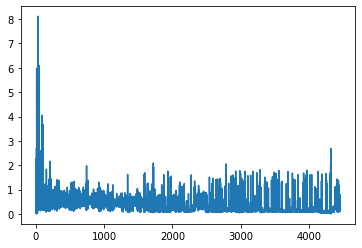

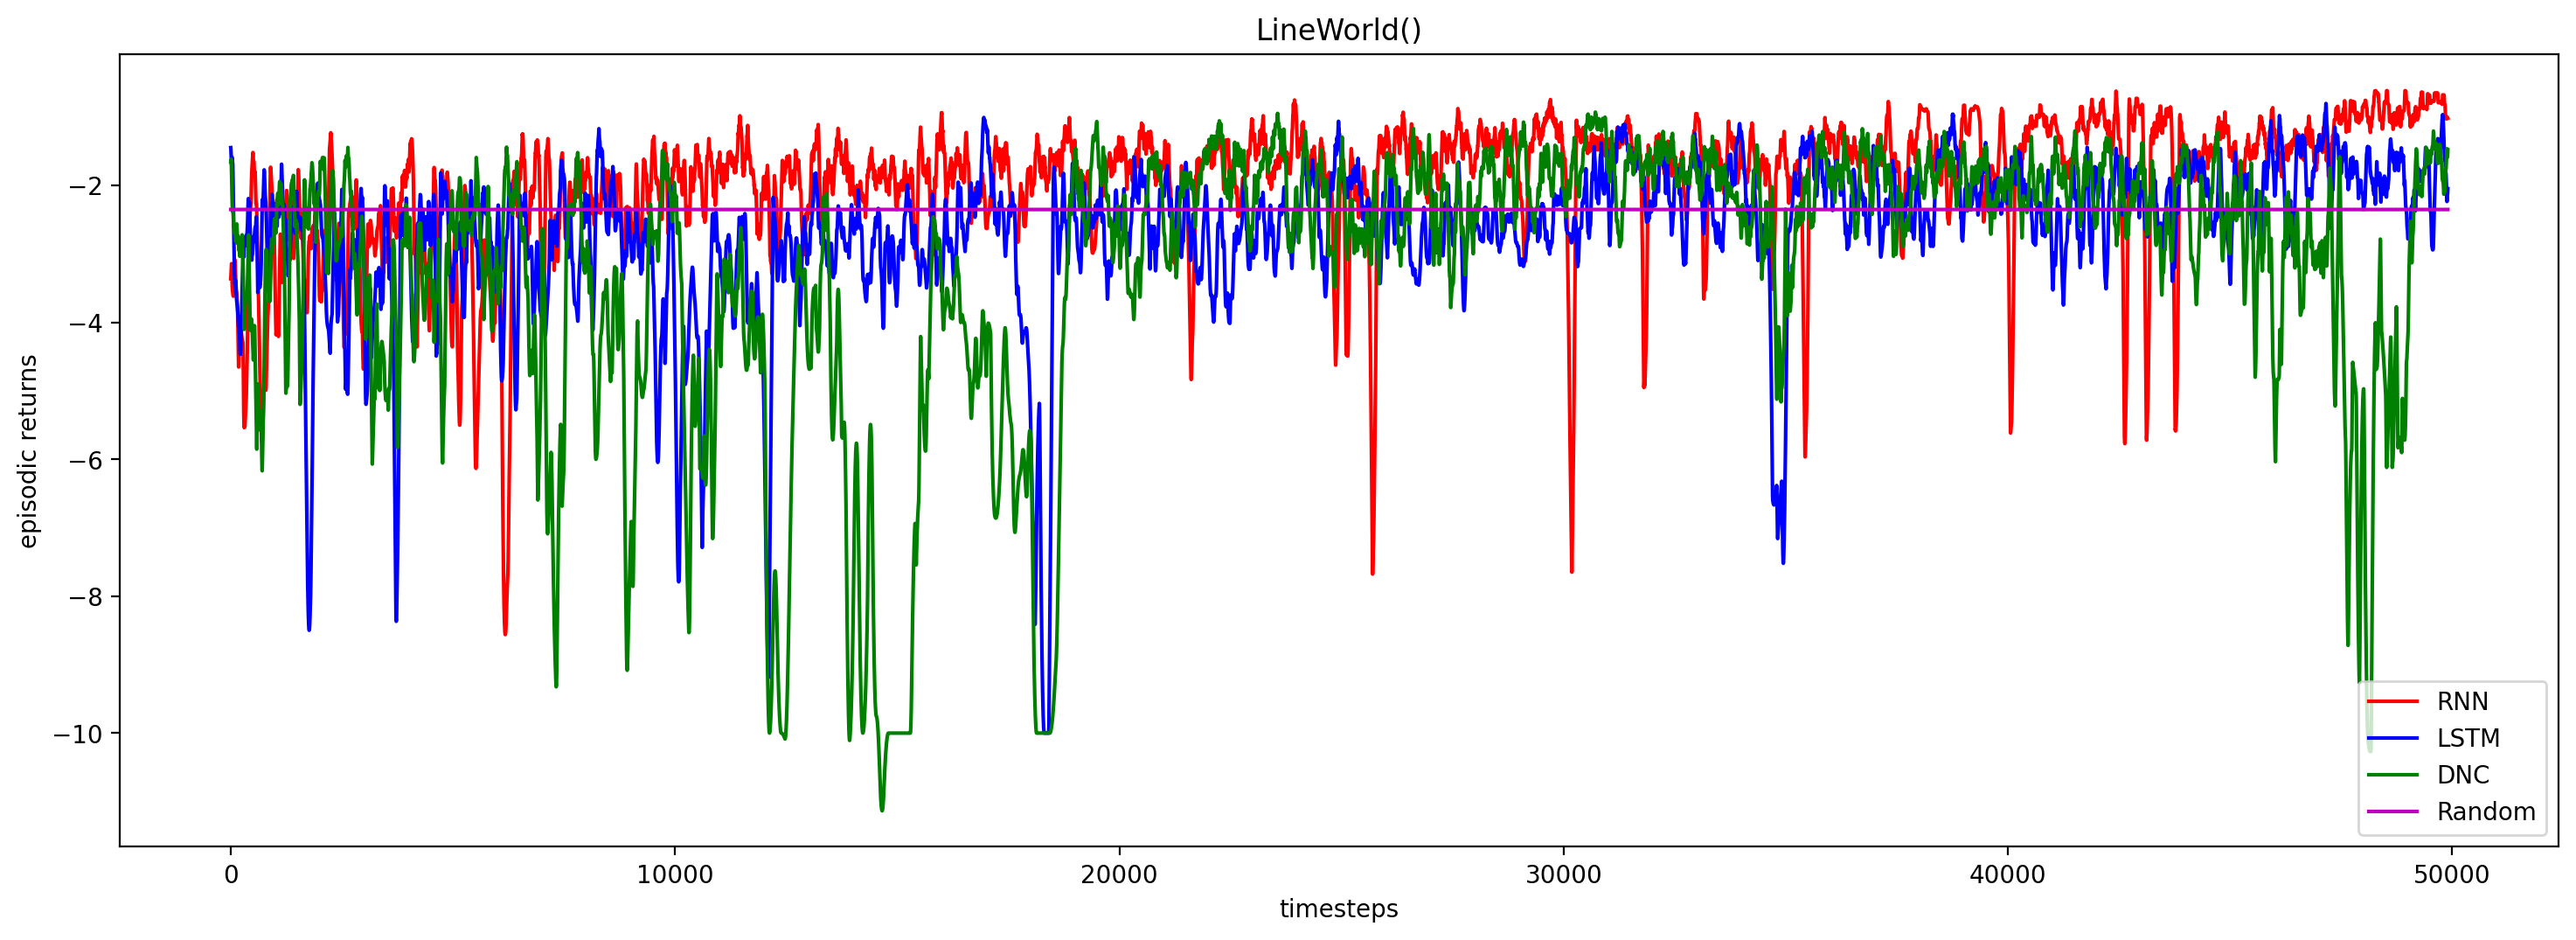

In [59]:
def train(env, agent, runs=1, ts_max=3000, store=False):
  no_episodes = 100
  horizon = 100
  track = True


  agents = []
  R_mat = []
  t_mat = []

  
  for r in tqdm(range(runs)):
    R_vec = []
    t_vec = []
    ts = 0
    printTs = 1000
    while ts<ts_max:
      if(ts - printTs > 0):
        printTs = printTs + 1000
        print('Learning, ts = ' + str(ts))
      state = env.reset()
      state = torch.tensor(state).unsqueeze(0).float()

      rewards, actions = [], []
      # Take actions in the environment based on present policy
      for t in range(horizon):
        
        action = agent.select_action(state)
        if(action==2):
          pass
          # import pdb; pdb.set_trace()
        state2, r, done, _ = env.step(action)
        rewards.append(r)
        actions.append(action)
        if(done):
          break

        # Concatenate states here
        state2 = torch.tensor(state2).unsqueeze(0).float()
        state = torch.cat((state,state2),0)
        ts += 1

      # States are stored in state: ts x num_features
      returns = np.zeros(len(rewards))
      G = 0
      for t in range(len(rewards)):
        G = 0.9 * G + rewards[len(rewards)-t-1]
        returns[len(rewards)-t-1] = np.sum(rewards[t:]) # CHECK: discounting

      # Use states, returns and actions to update value of states
      agent.update(state, actions, returns)

      R_vec.append(np.sum(rewards))
      t_vec.append(ts)

    R_mat.append(R_vec)
    t_mat.append(t_vec)
    agents.append(agent)

  plt.plot(agent.loss_vec), plt.show()

  if(store):
    return agents, t_mat, R_mat
  return t_mat, R_mat

# Testing on env 1
env = RememberLights(delay=5)
ts_max = 5000
eps = (1, 0.1, 3000)

# Testing on env 2
# ts_max = 50000
# eps = (1, 0.1, 30000)
# env = LineWorldMemory()

r_rnn = train(env, Agent(env, net='rnn', eps=eps), ts_max=ts_max, store=True)
r_dnc = train(env, Agent(env, net='dnc', eps=eps), ts_max=ts_max, store=True)
r_lstm = train(env, Agent(env, net='lstm', eps=eps), ts_max=ts_max, store=True)
# r_rand = train(env, Agent(env, net='rnn', eps=(1,1,1)), ts_max=ts_max)

rewards_dict = {
                'RNN': r_rnn[1:],
                'LSTM': r_lstm[1:],
                'DNC': r_dnc[1:],
                # 'Random': r_rand
                'Random': ([[0, ts_max]], [[-2.35, -2.35]])
               }
               

plot_rewards(rewards_dict, plot_seperate=False, clip=ts_max, title='LineWorld()', smooth=100)

In [0]:
np.mean(r_rand[1][0])

-2.357473684210526

tensor([[0., 0., 1., 0., 0., 0., 0.]]) 0


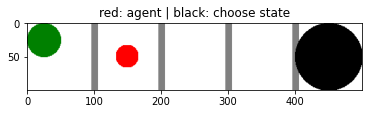

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]]) 0


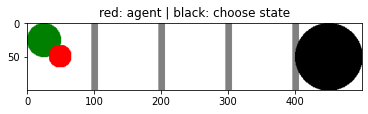

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.]]) 0


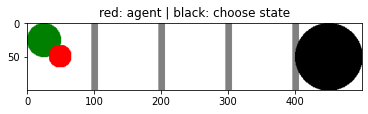

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.]]) 1


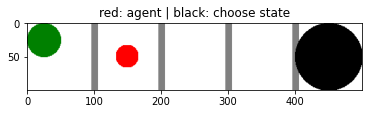

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.]]) 1


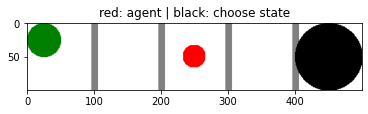

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]]) 1


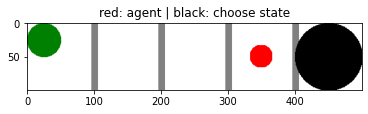

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]) 1


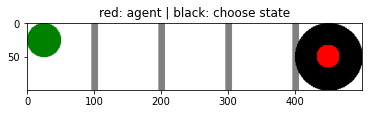

tensor([[0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]]) 1


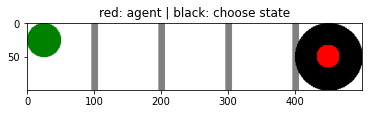

RuntimeError: ignored

In [0]:
# Visualize what the agent is doing
agent = r_rnn[0][0]
agent.eps=0

ts_max = 10
ts = 0
while ts < ts_max:
  state = env.reset()
  state = torch.tensor(state).unsqueeze(0).float()

  rewards, actions = [], []
  # Take actions in the environment based on present policy
  for t in range(100):
    
    action = agent.select_action(state)
    print(state, action)
    state2, r, done, _ = env.step(action)
    env.render()
    rewards.append(r)
    actions.append(action)
    if(done):
      raise

    # Concatenate states here
    state2 = torch.tensor(state2).unsqueeze(0).float()
    state = torch.cat((state,state2),0)
    ts += 1